In [3]:
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
%matplotlib inline

### Merging PATIENTS table with NOTEEVENTS

In [4]:
NOTEEVENTS = pd.read_csv('NOTEEVENTS_WITH_AGE.csv')
PATIENTS = pd.read_csv('PATIENTS.csv')

C:\Users\seanx\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
print("Number of unique subjects in PATIENTS: ", len(set(PATIENTS['SUBJECT_ID'])))
print("Number of rows in PATIENTS: ", len(PATIENTS))
print("Number of unique subjects in NOTEEVENTS_WITH_AGE: ", len(set(NOTEEVENTS['SUBJECT_ID'])))

Number of unique subjects in PATIENTS:  46520
Number of rows in PATIENTS:  46520
Number of unique subjects in NOTEEVENTS_WITH_AGE:  46146


In [19]:
#Joined df on Subject ID
df = NOTEEVENTS.merge(PATIENTS, how = 'left', on = 'SUBJECT_ID')

#Take only the subset columns to look at age
df['CHARTDATE'] = pd.to_datetime(df['CHARTDATE'], format='%Y-%m-%d' ).dt.date
df['DOB'] = pd.to_datetime(df['DOB'], format='%Y-%m-%d').dt.date
df['AGE_recalculated'] = df['CHARTDATE'] - df['DOB']
df['AGE_recalculated'] = [int(age.days//365.2425) for age in df['AGE_recalculated']]

In [ ]:
### Compari

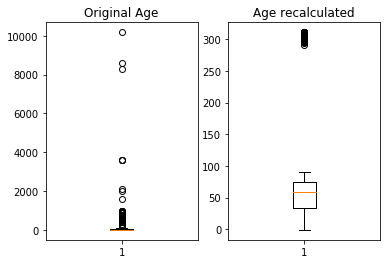

In [22]:
#Visualize difference between previously extracted age and recalculated age
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
ax1.set_title('Original Age')
ax1.boxplot(df['AGE'])

ax2.set_title('Age recalculated')
ax2.boxplot(df['AGE_recalculated'])

plt.show()

#According to MIMIC III: Patients > 89 years had DOB set to 300 years before first admission date. 
#Our boxplot corroborates this. We simply have to replace these with age = 90

In [7]:
#Replace values over 89 with 90
df['AGE_recalculated'] = df['AGE_recalculated'].apply(lambda x: x if x <= 89 else 90)

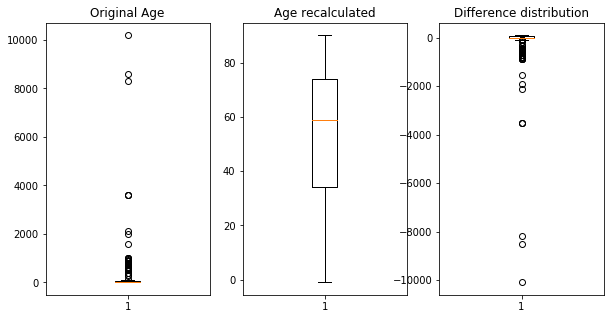

In [8]:
#Visualize difference between previously extracted age and recalculated age
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False)
ax1.set_title('Original Age')
ax1.boxplot(df['AGE'])

ax2.set_title('Age recalculated')
ax2.boxplot(df['AGE_recalculated'])

ax3.set_title('Difference distribution')
ax3.boxplot(df['AGE_recalculated']-df['AGE'])
f.set_figwidth(10)
f.set_figheight(5)
plt.show()

In [55]:
print('Original age: Number of AGE==0: {0}, %total: {1}%'.format(sum(df['AGE']==0), round(sum(df['AGE']==0)/len(NOTEEVENTS)*100, 2)))
print('Recalculated age: Number of AGE==0: {0}, %total: {1}%'.format(sum(df['AGE_recalculated']==0), round(sum(df['AGE_recalculated']==0)/len(NOTEEVENTS)*100, 2)))

Original age: Number of AGE==0: 1288026, %total: 61.83%
Recalculated age: Number of AGE==0: 425400, %total: 20.42%


### Function to merge, calculate, and clean age

In [23]:
def merge_calculate_age(df1: pd.DataFrame, df_patients: pd.DataFrame, admission_column_name:str = 'CHARTDATE') -> pd.Series:
    '''Takes a MIMIC III dataset with SUBJECT_ID and merges it with PATIENTS table based on SUBJECT ID and calculates AGE'''
    #Merge on SUBJECT_ID
    df = df1.merge(df_patients, how = 'left', on = 'SUBJECT_ID')
    #Convert to datetime
    df[admission_column_name] = pd.to_datetime(df[admission_column_name], format='%Y-%m-%d').dt.date
    df['DOB'] = pd.to_datetime(df['DOB'], format='%Y-%m-%d').dt.date
    #Subtract dates
    df['AGE_recalculated'] = df[admission_column_name] - df['DOB']
    #Calculate year. Note that year is calculated by dividing #days by 365.2425
    df['AGE_recalculated'] = [int(age.days//365.2425) for age in df['AGE_recalculated']]
    #Clean age. Since data is deidentified, any age>89 was set to ~300. Replace all these ages with 90
    df['AGE_recalculated'] = df['AGE_recalculated'].apply(lambda x: x if x <= 89 else 90)

    return df['AGE_recalculated']